In [1]:
# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import urllib.request

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def load_data():
    path = 'data/StudentsPerformance.csv'
    return pd.read_csv(path)

data = load_data()
data.head()

# data["test preparation course"].unique()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Convert all features into numerical values so we can calculate R values

In [3]:
# Convert everything into numbers for calculating Pearson's R
# def genderToNum(row):
#     if (row["gender"] == "male"):
#         return 1,0
#     else:
#         return 0,1

# def raceToNum(row):
    # if row["race/ethnicity"][-1] == "A":
    #     return 1
    # elif row["race/ethnicity"][-1] == "B":
    #     return 0.75
    # elif row["race/ethnicity"][-1] == "C":
    #     return 0.5
    # elif row["race/ethnicity"][-1] == "D":
    #     return 0.25
    # elif row["race/ethnicity"][-1] == "E":
    #     return 0

# def lunchToNum(row):
#     if row["lunch"] == "standard":
#         return 0
#     else:
#         return 1

# def prepToNum(row):
#     if row["test preparation course"] == "none":
#         return 0
#     else:
#         return 1
        
def binIt(row):
    if (row["math score"] >= 70):
        return "A"
    elif (row["math score"] >= 60):
        return "B"
    elif (row["math score"] >= 50):
        return "C"
    elif (row["math score"] >= 40):
        return "D"
    else:
        return "F"


def eduToNum(row):
    if row["parental level of education"] == "some high school":
        return 0
    elif row["parental level of education"] == "high school":
        return 1
    elif row["parental level of education"] == "some college":
        return 2
    elif row["parental level of education"] == "associate's degree":
        return 3
    elif row["parental level of education"] == "bachelor's degree":
        return 4
    elif row["parental level of education"] == "master's degree":
        return 5

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories='auto')
data[enc.categories_[0]] = enc.fit_transform(data[["gender"]]).toarray()
data[enc.categories_[0]] = enc.fit_transform(data[["race/ethnicity"]]).toarray()
data[enc.categories_[0]] = enc.fit_transform(data[["lunch"]]).toarray()
data[enc.categories_[0]] = enc.fit_transform(data[["test preparation course"]]).toarray()
# Rename the features to better describe
data = data.rename(columns={'group A': 'ethnicity_A', 'group B': 'ethnicity_B', 'group C': 'ethnicity_C', 'group D': 'ethnicity_D', 'group E': 'ethnicity_E', 'free/reduced': 'reduced_free_lunch', 'standard' : 'standard_lunch', 'completed' : 'done_test_prep', 'none': 'no_test_prep'})

# Remove unnecessary original features
data = data.drop(columns=["race/ethnicity", "gender", "lunch", "test preparation course"])

data["parental level of education"] = data.apply(eduToNum, axis=1)

# Bin the scores, comment this out if you want to see the real precision and accuracy scores
# data["math score"] = pd.cut(data["math score"], 11, labels=[0,10,20,30,40,50,60,70,80,90,100])
# data["reading score"] = pd.cut(data["reading score"], 11, labels=[0,10,20,30,40,50,60,70,80,90,100])
# data["writing score"] = pd.cut(data["writing score"], 11, labels=[0,10,20,30,40,50,60,70,80,90,100])

# Comment this out if you want to see the top correlating features
data["math score"] = data.apply(binIt, axis=1)

data.head()

,parental level of education,math score,reading score,writing score,female,male,ethnicity_A,ethnicity_B,ethnicity_C,ethnicity_D,ethnicity_E,reduced_free_lunch,standard_lunch,done_test_prep,no_test_prep
0,4,A,72,74,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,2,B,90,88,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,5,A,95,93,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,3,D,57,44,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,2,A,78,75,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


Find and order the Pearson's R values for each feature against each math/reading/writing score

In [246]:
import math
import statistics

def printDict(list):
    for x in list:
        print("{}:  {}".format(x[0], x[1]))
    print("\n")

# Get the Pearson's R value between each feature and the different scores
mathlist = {}
for x in data.keys():
    if x == "math score":
        continue
    mathlist[x] = abs(np.corrcoef(data[x], data["math score"])[0][1])
mathlist = sorted(mathlist.items(), key=lambda x:x[1], reverse=True)
print("Features against Math scores")
printDict(mathlist)

readinglist = {}
for x in data.keys():
    if x == "reading score":
        continue
    readinglist[x] = abs(np.corrcoef(data[x], data["reading score"])[0][1])
readinglist = sorted(readinglist.items(), key=lambda x:x[1], reverse=True)
print("Features against Reading scores")
printDict(readinglist)

writinglist = {}
for x in data.keys():
    if x == "writing score":
        continue
    writinglist[x] = abs(np.corrcoef(data[x], data["writing score"])[0][1])
writinglist = sorted(writinglist.items(), key=lambda x:x[1], reverse=True)
print("Features against Writing scores")
printDict(writinglist)

Features against Math scores
reading score:  0.8000552137569866
writing score:  0.7868280279608924
reduced_free_lunch:  0.341123623094806
standard_lunch:  0.341123623094806
ethnicity_E:  0.2033527157377754
done_test_prep:  0.18195728709343026
no_test_prep:  0.18195728709343026
female:  0.15572149443040945
male:  0.15572149443040945
parental level of education:  0.1548809063335386
ethnicity_A:  0.09089889896748152
ethnicity_B:  0.08127248654189699
ethnicity_C:  0.07200720897696515
ethnicity_D:  0.047227905156660206


Features against Reading scores
writing score:  0.9357221738965641
math score:  0.8000552137569865
female:  0.24467977741685099
male:  0.24467977741685099
done_test_prep:  0.23776166411721816
no_test_prep:  0.23776166411721816
reduced_free_lunch:  0.22934256048731697
standard_lunch:  0.22934256048731697
parental level of education:  0.19060455223044856
ethnicity_E:  0.10725423753462626
ethnicity_A:  0.0951835549432119
ethnicity_B:  0.059395889976857894
ethnicity_D:  0.03868

Univariate Selection for top features

In [247]:
# This was all essentially from the recommended webpage on feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

x = data.iloc[:,0:20]    # Select all columns for the selection process
x = x.drop(columns=["math score"])  # drop math score from the selection process as it is the target column
y = data.iloc[:,1] # The target column is the math score

bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['features', 'score']
print(featureScores.nlargest(15,'score'))

                       features        score
1                 reading score  3790.069998
2                 writing score  3214.215212
10           reduced_free_lunch    81.741465
9                   ethnicity_E    48.278483
11               standard_lunch    44.989488
0   parental level of education    37.880988
12               done_test_prep    23.957375
8                   ethnicity_D    16.559499
4                          male    15.042384
5                   ethnicity_A    14.394842
6                   ethnicity_B    14.167133
3                        female    13.996967
13                 no_test_prep    13.359408
7                   ethnicity_C     8.984633


Notably, test preparation course is considered to have a stronger relationship to math score in the Univariate Selection than in the Pearson's R method

Assuming we are focussing on the maths score as the target attribute, we will create data sets of sizes 6, 4, and 2 of the features that correlate strongest with the maths score. The new data sets are written to separate csv files

This uses the correlation scores from Univariate Selection

In [5]:
import csv

# Top 2
# writing, reading
topTwo = data[["writing score", "reading score"]]
topTwo.to_csv('data/topTwoStudentPerf.csv', index=False)

# Top 4
# writing, reading, lunch, test prep
topFive = data[["writing score", "reading score", "standard_lunch", "ethnicity_E", "parental level of education"]]
topFive.to_csv('data/topFiveStudentPerf.csv', index=False)

# Top 6
# writing, reading, lunch, test prep, gender, ethnicity
topTen = data[["writing score", "reading score", "standard_lunch", "ethnicity_E", "parental level of education", "ethnicity_B", "reduced_free_lunch", "ethnicity_A", "no_test_prep", "ethnicity_D"]]
topTen.to_csv('data/topTenStudentPerf.csv', index=False)

Use test/train split to separate the data and use linear regression as the classifier

In [308]:
%pip install yellowbrick

     -------------------------------------- 282.6/282.6 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Test set used: topTwo
Test set score: 0.50
Test set accuracy: 0.5	Test set precision: 0.5
True Positive Rate (Recall): 0.5	False Positive Rate: 0.5
F-Measure: 0.5
Roc Area Under Curve score: 0.7860825629886455

Test set used: topFive
Test set score: 0.50
Test set accuracy: 0.504	Test set precision: 0.504
True Positive Rate (Recall): 0.504	False Positive Rate: 0.496
F-Measure: 0.504
Roc Area Under Curve score: 0.7851246066193778

Test set used: topTen
Test set score: 0.49
Test set accuracy: 0.492	Test set precision: 0.492
True Positive Rate (Recall): 0.492	False Positive Rate: 0.508
F-Measure: 0.492
Roc Area Under Curve score: 0.7842367662327235



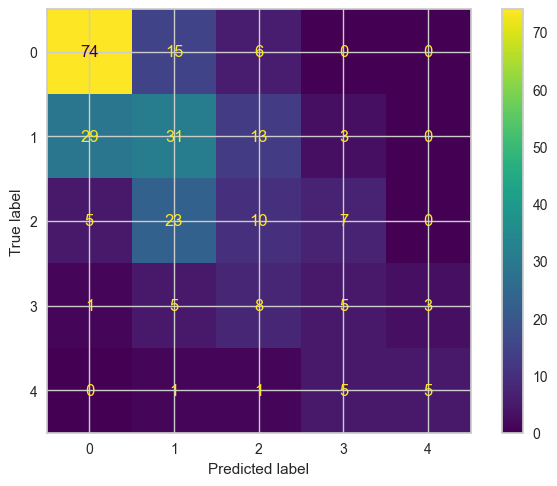

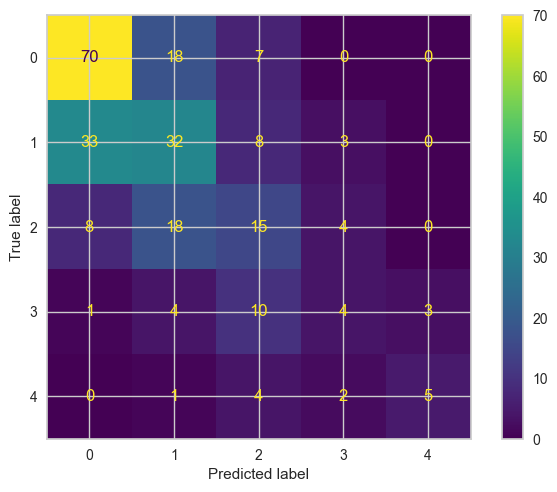

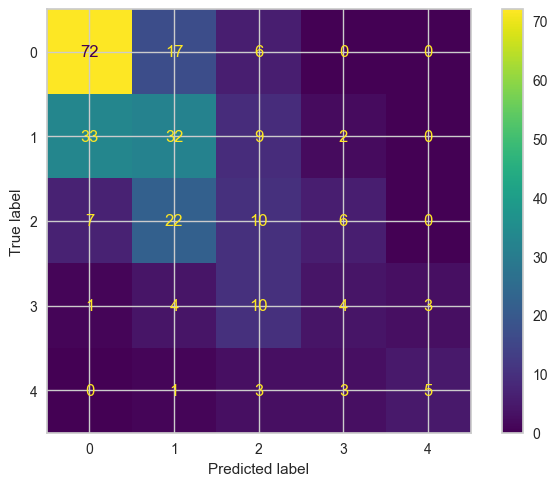

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from sklearn.neighbors import KNeighborsClassifier


# For multiclass ROC curve plotting
# from yellowbrick.classifier import ROCAUC

diffDataSets = [topTwo, topFive, topTen]
dataSetNames = ["topTwo", "topFive", "topTen"]      # This is for easier output interpretation
target = data["math score"]
# d = data.drop(columns=["math score"])   # Remove the target column from the data

count = 0
for x in diffDataSets:
    x_train, x_test, y_train, y_test = train_test_split(x, target, random_state=0)  # split the data in to test and train

    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='micro')

    print("Test set used: {}".format(dataSetNames[count]))
    print("Test set score: {:.2f}".format(knn.score(x_test, y_test))) # evaluate the accuracy  of your classifier 
    print("Test set accuracy: {}\tTest set precision: {}".format(acc,prec))


    # Create and plot confusion matrix
    conf =confusion_matrix(y_test, y_pred, labels=["A","B","C","D","F"])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    
    FP = (conf.sum(axis=0) - np.diag(conf)).sum()
    FN = (conf.sum(axis=1) - np.diag(conf)).sum()
    TP = (np.diag(conf)).sum()
    TN = (conf.sum() - (FP + FN + TP)).sum()

    TPRate = TP/(TP+FN)         # Or Recall
    FPRate = FP/(TP+FN)
    print("True Positive Rate (Recall): {}\tFalse Positive Rate: {}".format(TPRate, FPRate))
    fmeasure = (2 * TPRate * prec) / (TPRate + prec)
    print("F-Measure: {}".format(fmeasure))

    # Recall, Accuracy, Precision, F-Measure all appear to be the same. Means sensistivity == specificity?

    print("Roc Area Under Curve score: {}\n".format(roc_auc_score(y_test, knn.predict_proba(x_test), multi_class='ovr')))


    # ALL THIS STUFF LINEAR REGRESSION (APPARENTLY BAD FOR THE LAB)
    
    # lr = LinearRegression().fit(x_train, y_train)   # Create a linear regression classifier and fit the train data into the model
    # y_predlr = lr.predict(x_test)   # predict the math score on the test data

    # # print("Test set predictions for {}:\n{}".format(dataSetNames[count], y_predlr)) # print out the predictions for the test data 

    # # bin the predictions so it fits with the accuaracy/precision scores
    # y_predlrRounded = pd.cut(y_predlr, 11, labels=[0,10,20,30,40,50,60,70,80,90,100])

    # print("Test set used: {}".format(dataSetNames[count]))
    # print("Test set score: {:.2f}".format(lr.score(x_test, y_test))) # evaluate the accuracy  of your classifier 
    # print("Test set accuracy: {}\tTest set precision: {}".format(accuracy_score(y_test, y_predlrRounded),precision_score(y_test, y_predlrRounded, average='micro')))

    # # Create and plot confusion matrix
    # conf =confusion_matrix(y_test, y_predlrRounded)
    # disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    # disp.plot()
    
    # FP = (conf.sum(axis=0) - np.diag(conf)).sum()
    # FN = (conf.sum(axis=1) - np.diag(conf)).sum()
    # TP = (np.diag(conf)).sum()
    # TN = (conf.sum() - (FP + FN + TP)).sum()

    # TPRate = TP/(TP+FN)
    # FPRate = FP/(TP+FN)
    # print("True Positive Rate: {}\tFalse Positive Rate: {}\n".format(TPRate, FPRate))

    count = count + 1

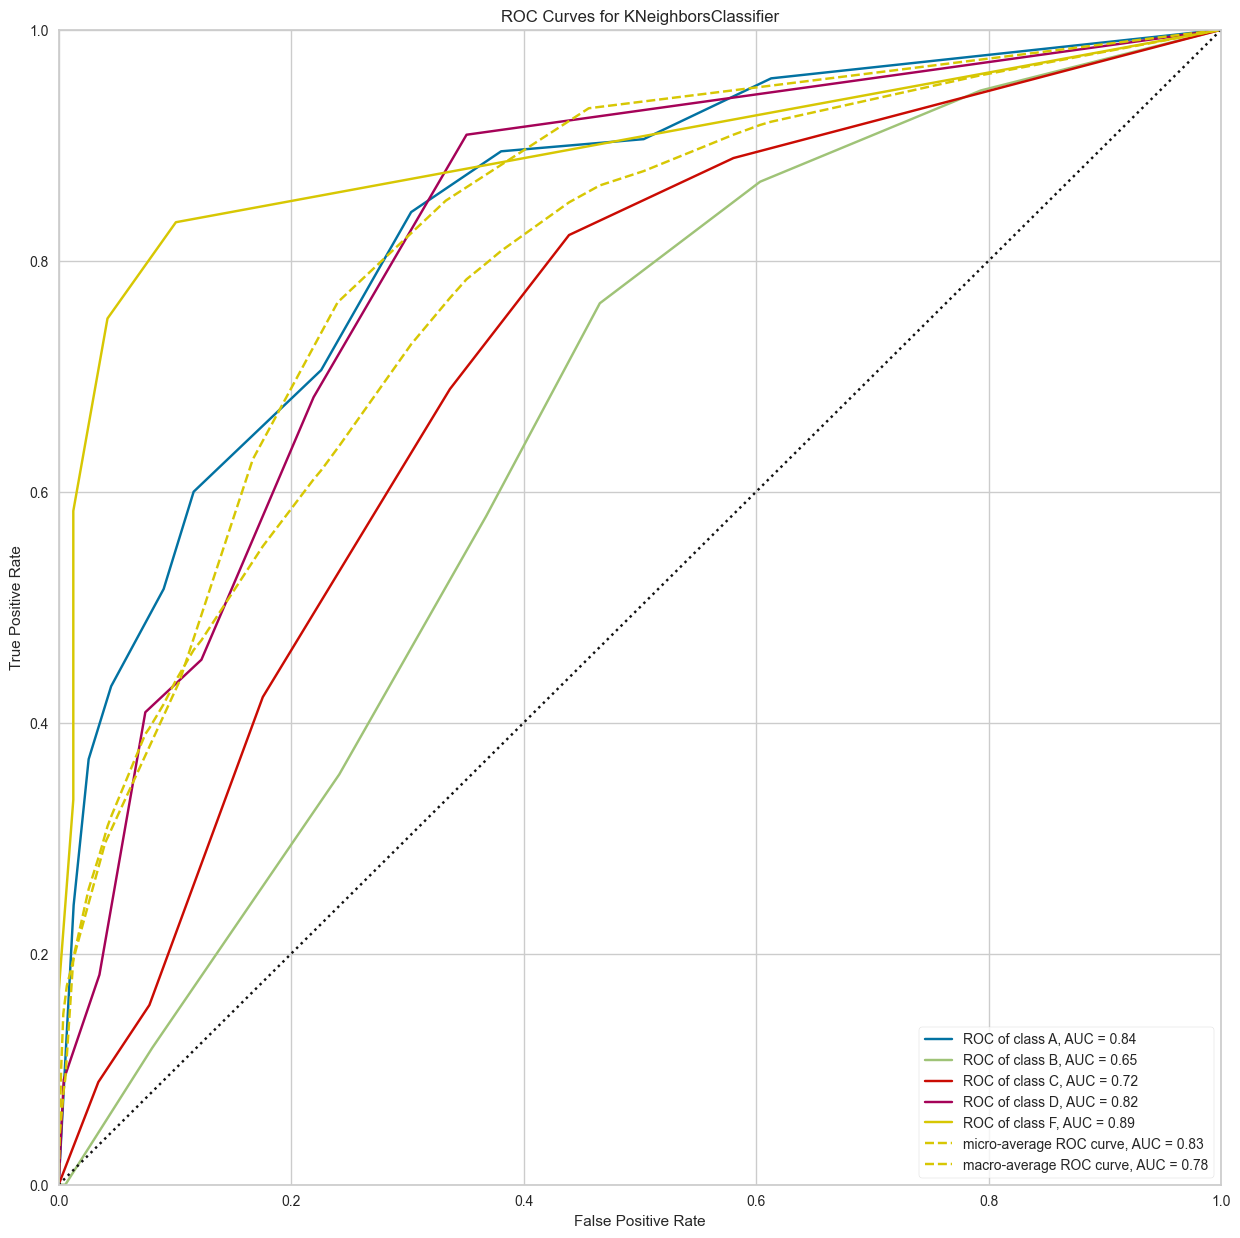

<AxesSubplot: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [8]:
# For multiclass ROC curve plotting
from yellowbrick.classifier import ROCAUC
x_train, x_test, y_train, y_test = train_test_split(topTen, target, random_state=0)  # split the data in to test and train

model = KNeighborsClassifier(n_neighbors=10)
knn = ROCAUC(model, classes=["A", "B", "C", "D", "F"], size=(1500, 1500))
knn.fit(x_train, y_train)
knn.score(x_test,y_test)
knn.show()